# Exploration and Modeling of 2013 NYC Taxi Trip and Fare Dataset on Spark 2.0 HDInsight Clusters (pySpark3)

---------------------------------
### Here we show key features and capabilities of Spark's MLlib toolkit using the NYC taxi trip and fare data-set from 2013 (about 40 Gb uncompressed). We take about 10% of the sample of this data (from the month of December 2013, about 3.6 Gb) to predict the amount of tip paid for each taxi trip in NYC based on features such as trip distance, number of passengers, trip distance etc. We have shown relevant plots in Python.

### We have sampled the data in order for the runs to finish quickly. The same code (with minor modifications) can be run on the full 2013 data-set.

### This notebook takes about 15 mins to run on a 2 worker-node cluster(D12_V2).


### The nobebook runs in the PySpark3 kernel in Jupyter.
----------------------------------

### OBJECTIVE: Show use of Spark MLlib's functions for featurization and ML tasks.

### The learning task is to predict the amount of tip paid in (dollars) paid for each taxi trip in December 2013

#### We have shown the following steps:
1. Data ingestion, joining, and wrangling.
2. Data exploration and plotting.
3. Data preparation (featurizing/transformation).
4. Modeling (using incl. hyperparameter tuning with cross-validation), prediction, model persistance.
5. Model evaluation on an independent validation data-set.

Through the above steps we highlight Spark SQL, as well as, MLlib's modeling and transformation functions.

### Introductory material

NYC 2013 Taxi data:
http://www.andresmh.com/nyctaxitrips/

----------------------------------

## Set directory paths and location of training, validation files, as well as model location in blob storage
NOTE: The blob storage attached to the HDI cluster is referenced as: wasb:/// (Windows Azure Storage Blob). Other blob storage accounts are referenced as: wasb://

In [1]:
# 1. Location of training data: contains Dec 2013 trip and fare data from NYC 
trip_file_loc = "wasb://data@cdspsparksamples.blob.core.windows.net/NYCTaxi/KDD2016/trip_data_12.csv"
fare_file_loc = "wasb://data@cdspsparksamples.blob.core.windows.net/NYCTaxi/KDD2016/trip_fare_12.csv"

# 2. Location of the joined taxi+fare training file
taxi_valid_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Valid.csv"

# 3. Set model storage directory path. This is where models will be saved.
modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; # The last backslash is needed;

# 4. Set data storage path. This is where data is sotred on the blob attached to the cluster.
dataDir = "wasb:///HdiSamples/HdiSamples/NYCTaxi/"; # The last backslash is needed;

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
70,application_1499674741924_0074,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.


## Set SQL context and import necessary libraries

In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import datetime

sqlContext = SQLContext(sc)

/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

## Data ingestion and wrangling using Spark SQL

#### Data import and registering as tables

In [3]:
## READ IN TRIP DATA FRAME FROM CSV
trip = spark.read.csv(path=trip_file_loc, header=True, inferSchema=True)

## READ IN FARE DATA FRAME FROM CSV
fare = spark.read.csv(path=fare_file_loc, header=True, inferSchema=True)

In [4]:
## CHECK SCHEMA OF TRIP AND FARE TABLES
trip.printSchema()
fare.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable 

In [5]:
## REGISTER DATA-FRAMEs AS A TEMP-TABLEs IN SQL-CONTEXT
trip.createOrReplaceTempView("trip")
fare.createOrReplaceTempView("fare")

#### Using Spark SQL to join, clean and featurize data

In [6]:
## USING SQL: MERGE TRIP AND FARE DATA-SETS TO CREATE A JOINED DATA-FRAME
## ELIMINATE SOME COLUMNS, AND FILTER ROWS WTIH VALUES OF SOME COLUMNS
sqlStatement = """SELECT t.medallion, t.hack_license,
  f.total_amount, f.tolls_amount,
  hour(f.pickup_datetime) as pickup_hour, f.vendor_id, f.fare_amount, 
  f.surcharge, f.tip_amount, f.payment_type, t.rate_code, 
  t.passenger_count, t.trip_distance, t.trip_time_in_secs 
  FROM trip t, fare f  
  WHERE t.medallion = f.medallion AND t.hack_license = f.hack_license 
  AND t.pickup_datetime = f.pickup_datetime 
  AND t.passenger_count > 0 and t.passenger_count < 8 
  AND f.tip_amount >= 0 AND f.tip_amount <= 25 
  AND f.fare_amount >= 1 AND f.fare_amount <= 250 
  AND f.tip_amount < f.fare_amount AND t.trip_distance > 0 
  AND t.trip_distance <= 100 AND t.trip_time_in_secs >= 30 
  AND t.trip_time_in_secs <= 7200 AND t.rate_code <= 5
  AND f.payment_type in ('CSH','CRD')"""
trip_fareDF = spark.sql(sqlStatement)

# REGISTER JOINED TRIP-FARE DF IN SQL-CONTEXT
trip_fareDF.createOrReplaceTempView("trip_fare")

In [7]:
## SHOW WHICH TABLES ARE REGISTERED IN SQL-CONTEXT
spark.sql("show tables").show()

+---------------+-----------+
|      tableName|isTemporary|
+---------------+-----------+
|hivesampletable|      false|
|           hvac|      false|
|          hvac1|      false|
|      hvactable|      false|
|     hvactable1|      false|
|   hvactable120|      false|
|     hvactable2|      false|
|           fare|       true|
|           trip|       true|
|      trip_fare|       true|
+---------------+-----------+

#### Sample data for creating and evaluating model & save in blob

In [8]:
# SAMPLE 10% OF DATA, SPLIT INTO TRAIINING AND VALIDATION AND SAVE IN BLOB
trip_fare_featSampled = trip_fareDF.sample(False, 0.1, seed=1234)
trainfilename = dataDir + "TrainData";
trip_fare_featSampled.repartition(10).write.mode("overwrite").parquet(trainfilename)

## Data ingestion & cleanup: Read in the joined taxi trip and fare training file (as parquet), format and clean data, and create data-frame

The taxi trip and fare files were joined based on the instructions provided in: 
"https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/"

In [9]:
## READ IN DATA FRAME FROM CSV
taxi_train_df = spark.read.parquet(trainfilename)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_train_cleaned = taxi_train_df.drop('medallion').drop('hack_license').drop('total_amount').drop('tolls_amount')\
    .filter("passenger_count > 0 and passenger_count < 8 AND tip_amount >= 0 AND tip_amount < 15 AND \
            fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND \
            trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## PERSIST AND MATERIALIZE DF IN MEMORY    
taxi_df_train_cleaned.persist()
taxi_df_train_cleaned.count()

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_train_cleaned.createOrReplaceTempView("taxi_train")

In [10]:
taxi_df_train_cleaned.printSchema()

root
 |-- pickup_hour: integer (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)

<a name="exploration"></a>
## Data exploration & visualization: Plotting of target variables and features

#### First, summarize data using SQL, this outputs a Spark data frame. If the data-set is too large, it can be sampled

In [11]:
%%sql -q -o sqlResultsPD
SELECT fare_amount, passenger_count, tip_amount FROM taxi_train WHERE passenger_count > 0 AND passenger_count < 7 AND fare_amount > 0 AND fare_amount < 100 AND tip_amount > 0 AND tip_amount < 15

#### Plot histogram of tip amount, relationship between tip amount vs. other features

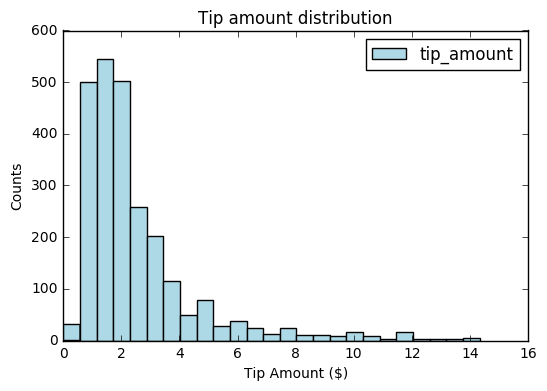

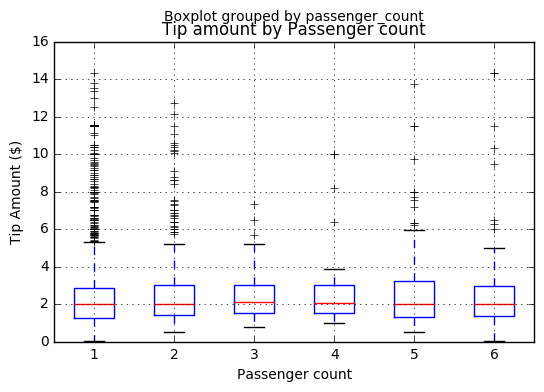

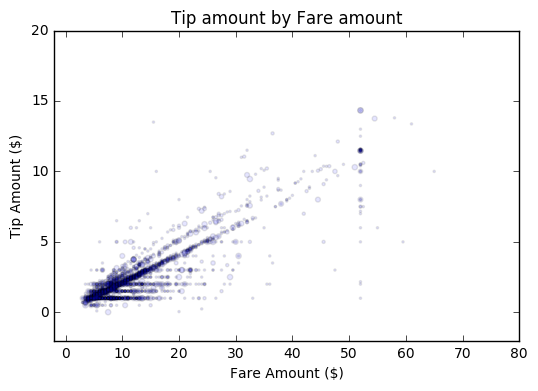

In [12]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
## %%local creates a pandas data-frame on the head node memory, from spark data-frame, 
## which can then be used for plotting. Here, sampling data is a good idea, depending on the memory of the head node

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP BY PASSENGER COUNT
ax2 = sqlResultsPD.boxplot(column=['tip_amount'], by=['passenger_count'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count'); ax2.set_ylabel('Tip Amount ($)');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResultsPD.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=2.5*(sqlResultsPD.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)'); ax.set_ylabel('Tip Amount ($)');
plt.axis([-2, 80, -2, 20])
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

<a name="transformation"></a>
## Feature engineering, transformation and data preparation for modeling

#### Create a new feature by binning hours into traffic time buckets using Spark SQL

In [13]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """SELECT payment_type, pickup_hour, fare_amount, tip_amount, 
    vendor_id, rate_code, passenger_count, trip_distance, trip_time_in_secs, 
  CASE
    WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN 'Night'
    WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN 'AMRush' 
    WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN 'Afternoon'
    WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN 'PMRush'
    END as TrafficTimeBins,
  CASE
    WHEN (tip_amount > 0) THEN 1 
    WHEN (tip_amount <= 0) THEN 0 
    END as tipped
  FROM taxi_train"""

taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

#### Indexing of categorical features
Here we only transform some variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

For indexing, we used stringIndexer function from MLlib.

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer

# DEFINE THE TRANSFORMATIONS THAT NEEDS TO BE APPLIED TO SOME OF THE FEATURES
sI1 = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex");
sI2 = StringIndexer(inputCol="rate_code", outputCol="rateIndex");
sI3 = StringIndexer(inputCol="payment_type", outputCol="paymentIndex");
sI4 = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex");

# APPLY TRANSFORMATIONS
encodedFinal = Pipeline(stages=[sI1, sI2, sI3, sI4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_train_with_newFeatures);

#### Split data into train/test. Training fraction will be used to create model, and testing fraction will be used to evaluate model.

In [15]:
trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;

# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
trainData, testData = encodedFinal.randomSplit([trainingFraction, testingFraction], seed=seed);

# CACHE DATA FRAMES IN MEMORY
trainData.persist(); trainData.count()
testData.persist(); testData.count()

343770

## Train a regression model: Predict the amount of tip paid for taxi trips

### Train Elastic Net regression model, and evaluate performance on test data

In [16]:
from pyspark.ml.feature import RFormula
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

## DEFINE REGRESSION FURMULA
regFormula = RFormula(formula="tip_amount ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex + pickup_hour + passenger_count + trip_time_in_secs + trip_distance + fare_amount")

## DEFINE INDEXER FOR CATEGORIAL VARIABLES
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32)

## DEFINE ELASTIC NET REGRESSOR
eNet = LinearRegression(featuresCol="indexedFeatures", maxIter=25, regParam=0.01, elasticNetParam=0.5)

## Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, eNet]).fit(trainData)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

## PLOC ACTUALS VS. PREDICTIONS
predictions.select("label","prediction").createOrReplaceTempView("tmp_results");

RMSE = 1.238221635659967
R-sqr = 0.3840714449337661

### Train Gradient Boosting Tree regression model, and evaluate performance on test data

In [17]:
from pyspark.ml.regression import GBTRegressor

## DEFINE REGRESSION FURMULA
regFormula = RFormula(formula="tip_amount ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex + pickup_hour + passenger_count + trip_time_in_secs + trip_distance + fare_amount")

## DEFINE INDEXER FOR CATEGORIAL VARIABLES
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32)

## DEFINE GRADIENT BOOSTING TREE REGRESSOR
gBT = GBTRegressor(featuresCol="indexedFeatures", maxIter=10)

## Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, gBT]).fit(trainData)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

## PLOC ACTUALS VS. PREDICTIONS
predictions.select("label","prediction").createOrReplaceTempView("tmp_results");

RMSE = 0.89929854991986
R-sqr = 0.7501851181231387

### Train a random forest regression model using the Pipeline function, save, and evaluate on test data set

In [18]:
from pyspark.ml.feature import RFormula
from sklearn.metrics import roc_curve,auc
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics

## DEFINE REGRESSION FURMULA
regFormula = RFormula(formula="tip_amount ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex + pickup_hour + passenger_count + trip_time_in_secs + trip_distance + fare_amount")

## DEFINE INDEXER FOR CATEGORIAL VARIABLES
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32)

## DEFINE RANDOM FOREST ESTIMATOR
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, 
                                   featureSubsetStrategy="auto",impurity='variance', maxDepth=6, maxBins=100)

## Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, randForest]).fit(trainData)

## SAVE MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "RandomForestRegressionModel_" + datestamp;
randForestDirfilename = modelDir + fileName;
model.save(randForestDirfilename)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

## PLOC ACTUALS VS. PREDICTIONS
predictions.select("label","prediction").createOrReplaceTempView("tmp_results");

RMSE = 0.922593135839523
R-sqr = 0.6790685010061757

In [19]:
%%sql -q -o predictionsPD
SELECT * from tmp_results

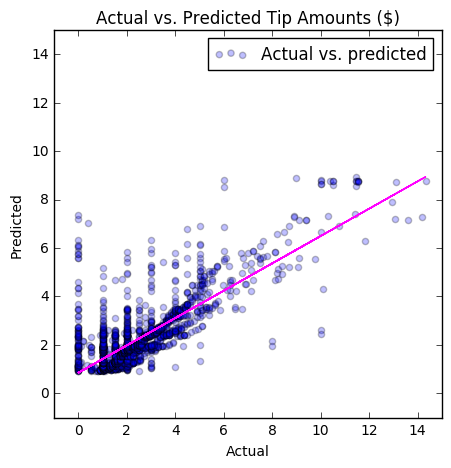

In [20]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 15])
plt.show(ax)

## Hyper-parameter tuning: Train a random forest model using cross-validation

In [21]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

## DEFINE RANDOM FOREST MODELS
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', 
                                   featureSubsetStrategy="auto",impurity='variance', maxBins=100)

## DEFINE MODELING PIPELINE, INCLUDING FORMULA, FEATURE TRANSFORMATIONS, AND ESTIMATOR
pipeline = Pipeline(stages=[regFormula, featureIndexer, randForest])

## DEFINE PARAMETER GRID FOR RANDOM FOREST
paramGrid = ParamGridBuilder() \
    .addGrid(randForest.numTrees, [10, 25, 50]) \
    .addGrid(randForest.maxDepth, [3, 5, 7]) \
    .build()

## DEFINE CROSS VALIDATION
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=3)

## TRAIN MODEL USING CV
cvModel = crossval.fit(trainData)

## PREDICT AND EVALUATE TEST DATA SET
predictions = cvModel.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

## SAVE THE BEST MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "CV_RandomForestRegressionModel_" + datestamp;
CVDirfilename = modelDir + fileName;
cvModel.bestModel.save(CVDirfilename);

R-squared on test data = 0.794106

## Load a saved pipeline model and evaluate it on test data set

In [22]:
from pyspark.ml import PipelineModel

savedModel = PipelineModel.load(randForestDirfilename)

predictions = savedModel.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

RMSE = 0.922593135839523
R-sqr = 0.6790685010061757

## Load and transform an independent validation data-set, and evaluate the saved pipeline model

### Note that this validation data, by design, has a different format than the original trainig data. By grangling and transformations, we make the data format the same as the training data for the purpose of scoring.

In [23]:
## READ IN DATA FRAME FROM CSV
taxi_valid_df = spark.read.csv(path=taxi_valid_file_loc, header=True, inferSchema=True)
taxi_valid_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_week: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- direct_distance: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)


In [24]:
## READ IN DATA FRAME FROM CSV
taxi_valid_df = spark.read.csv(path=taxi_valid_file_loc, header=True, inferSchema=True)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_valid_cleaned = taxi_valid_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') \
    AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 \
    AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_valid_cleaned.createOrReplaceTempView("taxi_valid")

### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_valid
"""
taxi_df_valid_with_newFeatures = spark.sql(sqlStatement)

## APPLY THE SAME TRANSFORATION ON THIS DATA AS ORIGINAL TRAINING DATA
encodedFinalValid = Pipeline(stages=[sI1, sI2, sI3, sI4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_valid_with_newFeatures)

In [25]:
## LOAD SAVED MODEL, SCORE VALIDATION DATA, AND EVALUATE
savedModel = PipelineModel.load(CVDirfilename)
predictions = savedModel.transform(encodedFinalValid)
r2 = evaluator.evaluate(predictions)
print("R-squared on validation data = %g" % r2)

R-squared on validation data = 0.787085

#### Save predictions to a file in HDFS

In [26]:
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "Predictions_CV_" + datestamp;
predictionfile = dataDir + fileName;
predictions.select("label","prediction").write.mode("overwrite").csv(predictionfile)